<a href="https://colab.research.google.com/github/Krizan99/Projekat-Algoritmi/blob/master/Copy_of_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p" -O data.zip && rm -rf /tmp/cookies.txt

--2021-09-07 20:10:30--  https://docs.google.com/uc?export=download&confirm=76xl&id=1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p
Resolving docs.google.com (docs.google.com)... 74.125.133.139, 74.125.133.101, 74.125.133.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.133.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-6g-docs.googleusercontent.com/docs/securesc/rbm6j6q26bmt6mpkgv45q4rnl84v7akq/j83uh9jnghld32sarnge6gitqdr010dn/1631045400000/06049624160957438625/01258430174463693752Z/1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p?e=download [following]
--2021-09-07 20:10:30--  https://doc-0s-6g-docs.googleusercontent.com/docs/securesc/rbm6j6q26bmt6mpkgv45q4rnl84v7akq/j83uh9jnghld32sarnge6gitqdr010dn/1631045400000/06049624160957438625/01258430174463693752Z/1tKOTjbtdxS-pzw80JHN-2FUiZA7htL7p?e=download
Resolving doc-0s-6g-docs.googleusercontent.com (doc-0s-6g-docs.googleusercontent.com)... 108.177.15.132, 2a00:1450:400c:c0c::84
Connecting

In [ ]:
import os

!mkdir '../input'
print(os.listdir("../input"))

[]


In [ ]:
!unzip data.zip

Archive:  data.zip
  inflating: Annotation.zip          
  inflating: all-dogs.zip            


In [ ]:
import zipfile

!mkdir '../input/annotation'

with zipfile.ZipFile("Annotation.zip","r") as zip_ref:
    zip_ref.extractall("../input/annotation")

In [ ]:
!mkdir '../input/all-dogs'

with zipfile.ZipFile("all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("../input/all-dogs")

In [ ]:
import numpy as np 
import pandas as pd

import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
dataroot = '../input/all-dogs'
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 30
lr = 0.0002
beta1 = 0.5
ngpu = 1
ComputeLB = False
DogsOnly = True

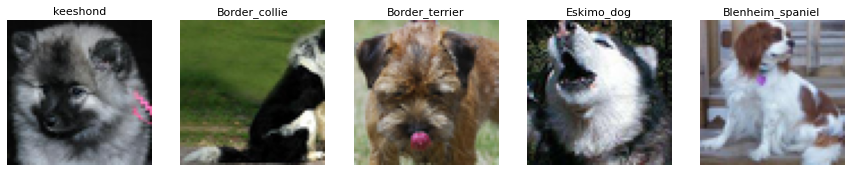

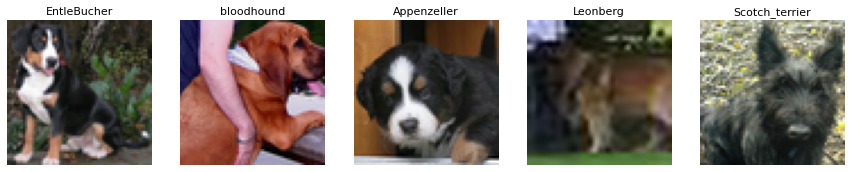

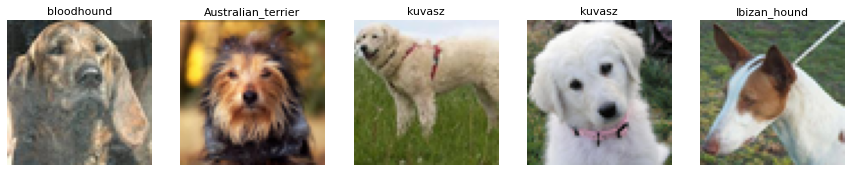

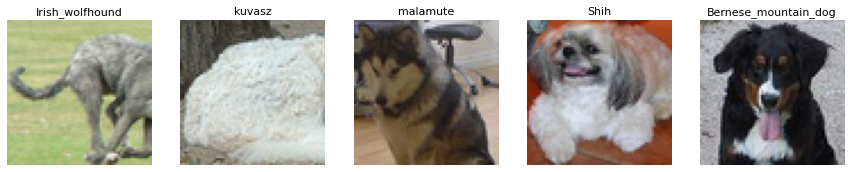

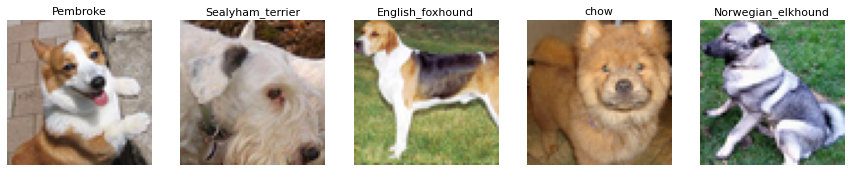

In [ ]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# iseci fotografije uz pomoć anotacija
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# random iseci sve fotografije
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# prikaz isečenih slika
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

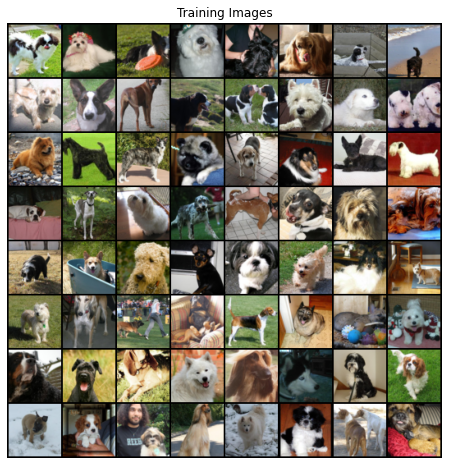

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.normal_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# Za svaku epohu
for epoch in range(num_epochs):
    # Za svaki skup u dataloaderu
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Treniranje sa skupom pravih fotografija
        netD.zero_grad()
        # Formatiranje skupa
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        # Prosleđivanje skupa pravih fotografija kroz D
        output = netD(real_cpu).view(-1)
        # Izračunati gubitak na skupu pravih fotografija
        errD_real = criterion(output, label)
        # Izračunati gradijente D u prolasku unazad
        errD_real.backward()
        D_x = output.mean().item()

        ## Treniranje sa skupom lažnih fotografija
        # Generisanje skupa latentnih vektora
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generisanje skupa lažnih slika pomoću G
        fake = netG(noise)
        label.fill_(fake_label)
        # Klasifikacija skupa lažnih slika pomoću D
        output = netD(fake.detach()).view(-1)
        # Izračunati gubitak D u skupu lažnih slika
        errD_fake = criterion(output, label)
        # Izračunati gradijente D u skupu lažnih slika
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Sumiranje gradijenata iz skupova pravih i lažnih slika
        errD = errD_real + errD_fake
        # Ažuriranje D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) # labela za lažne fotografije će biti labela pravih fotografija za generator
        # Zbog ažuriranja D, izvrši prolazak unapred za skup lažnih slika kroz D
        output = netD(fake).view(-1)
        # Izračunati gubitak G baziran na ovom izlazu
        errG = criterion(output, label)
        # Izračunati gradijente G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Ažuriranje G
        optimizerG.step()

        # Statistika izlaza treniranja
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Čuvanje gubitka za plotovanje kasnije
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Provera generatora čuvanjem izlaza G uz fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/161]	Loss_D: 1.8402	Loss_G: 4.0021	D(x): 0.2860	D(G(z)): 0.3316 / 0.0239
[0/30][50/161]	Loss_D: 0.3582	Loss_G: 18.8070	D(x): 0.7741	D(G(z)): 0.0000 / 0.0000
[0/30][100/161]	Loss_D: 0.6295	Loss_G: 2.7831	D(x): 0.7392	D(G(z)): 0.1449 / 0.0742
[0/30][150/161]	Loss_D: 0.4604	Loss_G: 3.1710	D(x): 0.7515	D(G(z)): 0.0901 / 0.0478
[1/30][0/161]	Loss_D: 0.5450	Loss_G: 2.8115	D(x): 0.7515	D(G(z)): 0.1521 / 0.0806
[1/30][50/161]	Loss_D: 0.3156	Loss_G: 4.7234	D(x): 0.8650	D(G(z)): 0.1308 / 0.0139
[1/30][100/161]	Loss_D: 0.1383	Loss_G: 5.2273	D(x): 0.9325	D(G(z)): 0.0613 / 0.0063
[1/30][150/161]	Loss_D: 1.0294	Loss_G: 0.6155	D(x): 0.4706	D(G(z)): 0.0508 / 0.5998
[2/30][0/161]	Loss_D: 0.9422	Loss_G: 2.3175	D(x): 0.5233	D(G(z)): 0.0148 / 0.1230
[2/30][50/161]	Loss_D: 0.9984	Loss_G: 5.1930	D(x): 0.9527	D(G(z)): 0.5637 / 0.0086
[2/30][100/161]	Loss_D: 0.3810	Loss_G: 3.1507	D(x): 0.8169	D(G(z)): 0.1283 / 0.0600
[2/30][150/161]	Loss_D: 0.3505	Loss_G: 3.7538	D(x): 0.8886

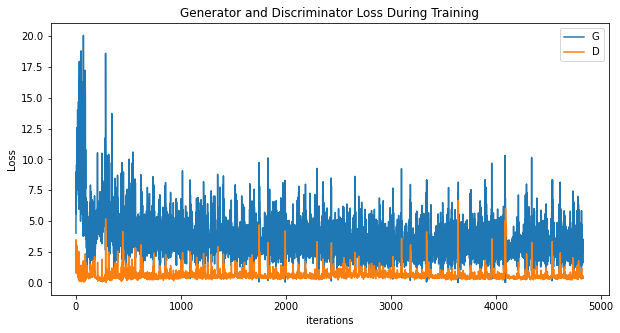

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

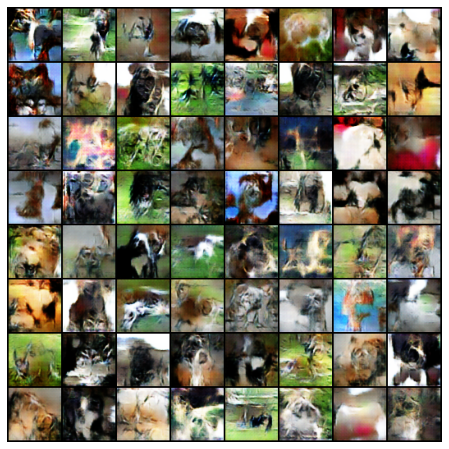

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]

In [ ]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')
print("Done")

Done
